# Devoir 2 (solutions): Méthode de la transformée inverse

## Exercice 1

### (a)

In [1]:
rand_gen <- function(x, trans = identity) {
    trans_vect <- Vectorize(trans)

    counter <- as.table(rep(0L, length(x)))
    names(counter) <- trans_vect(seq(0L, length.out = length(x)))

    p <- cumsum(x) / sum(x)

    function(n) {
        ret <- trans_vect(sapply(runif(n), function(y) sum(y > p)))
        counter <<- counter + table(factor(ret, names(counter)))

        ret
    }
}

### (b)

In [2]:
rand_trans <- function(sim, trans) rand_gen(environment(sim)[["x"]], trans)

### (c)

La fonction suivante fonctionne pour un nombre arbitraire d'arguments (ce qui n'était pas nécessaire pour répondre à la question).

In [3]:
rand_sum <- function(...) {
    xs <- lapply(list(...), function(s) {
        ret <- environment(s)[["x"]]
        names(ret) <- names(environment(s)[["counter"]])

        ret
    })

    new_support <- Reduce(union, lapply(xs, names))
    new_x <- numeric(length(new_support))
    names(new_x) <- new_support

    for (x in xs) {
        for (k in names(x))
            new_x[[k]] <- new_x[[k]] + x[[k]]
    }

    idx <- as.numeric(new_support) + 1L
    new_x0 <- numeric(tail(idx, 1L))
    new_x0[idx] <- new_x

    rand_gen(new_x0)
}

### (d)

In [4]:
rand_stats <- function(sim) proportions(environment(sim)[["counter"]])

### (e)

In [5]:
rand_hist <- function(sim) barplot(rand_stats(sim), space = 0L)

### Exemples

In [6]:
uni5 <- rand_gen(rep(1, 6))
bin5 <- rand_gen(c(1, 5, 10, 10, 5, 1) / 32)

In [7]:
sample_uni5 <- uni5(1e4)
sample_bin5 <- bin5(1e4)

In [8]:
mean(sample_uni5)
var(sample_uni5)

[1] 2.4998

[1] 2.922892

In [9]:
mean(sample_bin5)
var(sample_bin5)

[1] 2.4806

[1] 1.236547

In [10]:
rand_stats(uni5)

     0      1      2      3      4      5 
0.1673 0.1664 0.1659 0.1676 0.1652 0.1676 

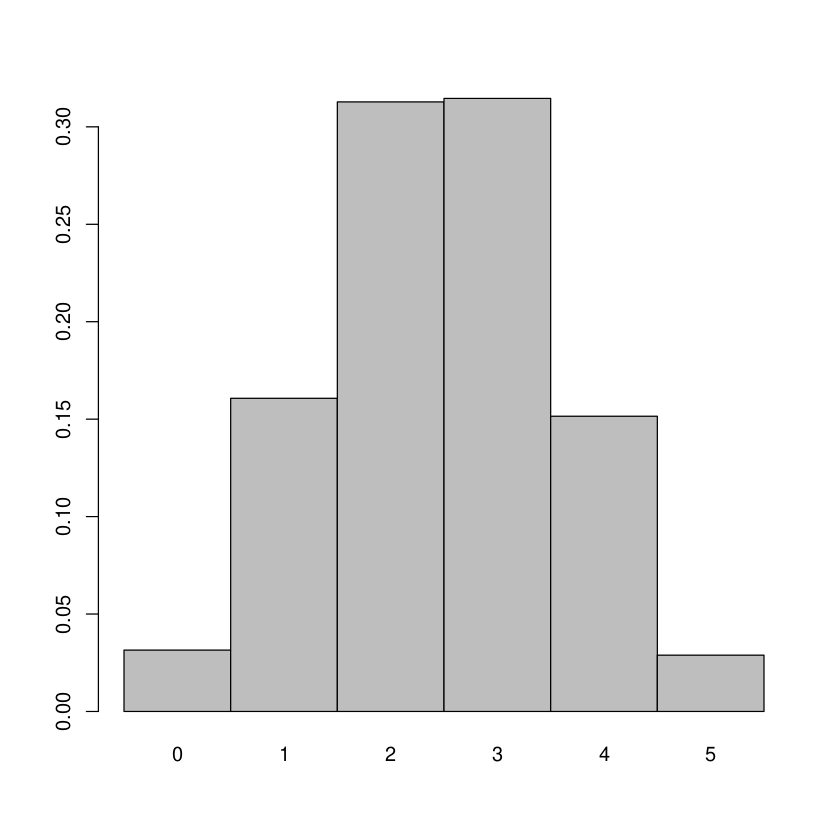

In [11]:
rand_hist(bin5)

In [12]:
uni_pair <- rand_trans(uni5, function(x) 2 * x)

In [13]:
bizarre <- rand_sum(uni5, uni_pair)

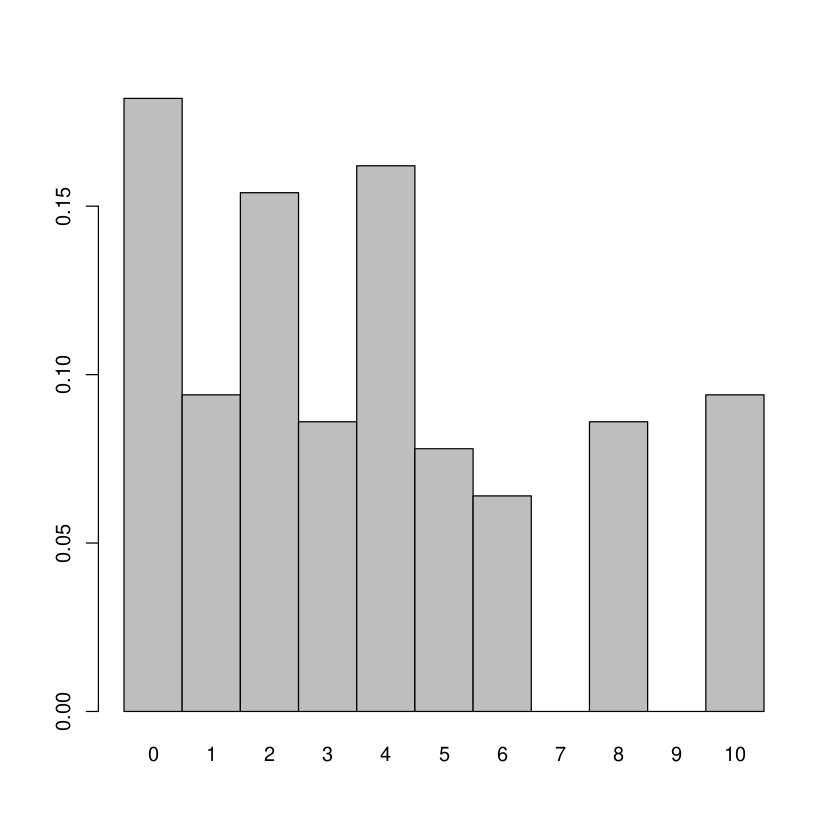

In [14]:
s1 <- bizarre(5e2)
rand_hist(bizarre)

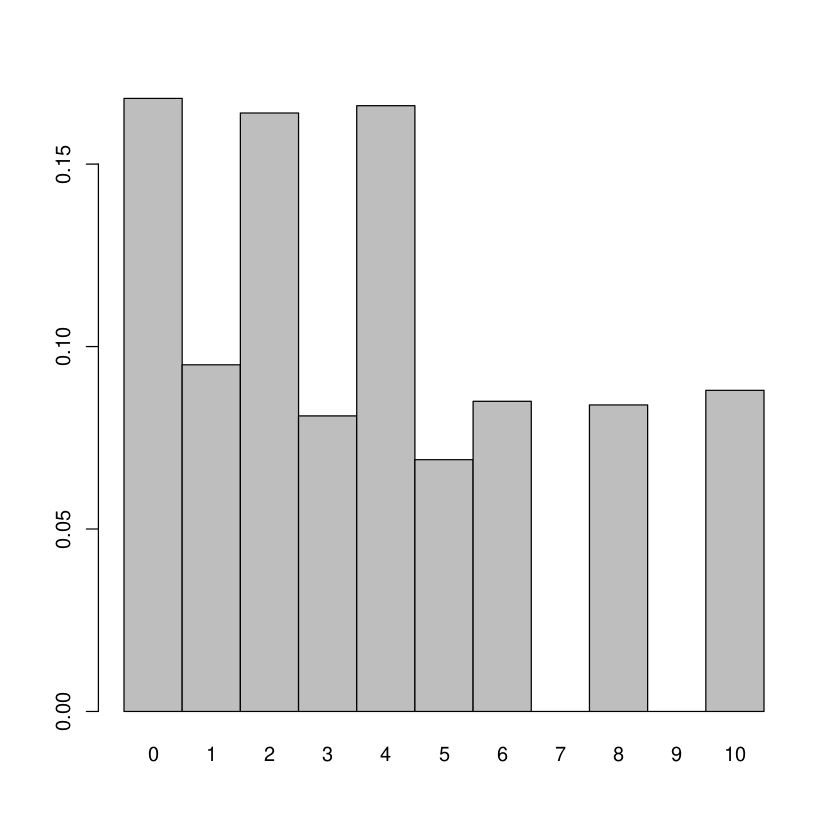

In [15]:
s2 <- bizarre(5e2)
rand_hist(bizarre)

## Exercice 2

In [16]:
exo2 <- function(chiffres = c(2L, 2L, 5L, 6L, 6L, 6L, 7L, 9L),
                 lb = -1e10,
                 ub = 1e10,
                 nb_iters = 1e5L) {
    op_match <- list(`+`, `-`, `*`, `/`, `^`)

    res <- replicate(n = nb_iters, simplify = FALSE, expr = {
        n <- sample(seq_along(chiffres)[-1L], 1L)
        chiffres_utilises <- sample(chiffres, n)

        ## Pour échantillonner les opérations à effectuer, on procède
        ## par conditionnement: (1) on échantillonne le nombre
        ## d'exponentiations, de multiplications/divisions et
        ## d'addition/soustractions et (2) on échantillone trois
        ## séquences d'opérations pour chacune de ces catégories. De
        ## cette manière, on n'a pas à se préoccuper de la priorité
        ## des opérations.
        ops_rep <- c(rmultinom(1L, n - 1L, rep(1L, 3)))
        ops_utilises <- c(rep(5L, ops_rep[[1L]]),
                          sample(3L:4L, ops_rep[[2L]], replace = TRUE),
                          sample(1L:2L, ops_rep[[3L]], replace = TRUE))

        res <- as.numeric(chiffres_utilises[[1L]])
        toRemove <- logical(n - 1L)
        for (k in 1L:(n - 1L)) {
            candidat <-
                op_match[[ops_utilises[k]]](res, chiffres_utilises[[k + 1L]])
            if (identical(ceiling(candidat), floor(candidat)))
                res <- as.numeric(candidat)
            else
                toRemove[k] <- TRUE
        }

        list(x = res,
             chiffres = chiffres_utilises[c(TRUE, !toRemove)],
             ops = ops_utilises[!toRemove])
    })
    ## Enlève les nombres situés à l'extérieur des limites.
    res <- Filter(x = res, f = function(t) t[["x"]] <= ub & t[["x"]] >= lb)

    ## Enlève les doublons. Pour ce faire, la première étape est
    ## d'ordonner les résultats.
    res_trans <- do.call(rbind, res)
    xs <- as.numeric(res_trans[,1L])
    xs_order <- order(xs)
    xs <- xs[xs_order]

    ## Trouve les indices des doublons.
    doublons <- which(head(xs, -1L) == tail(xs, -1L)) + 1L
    n <- length(xs) - length(doublons)
    if (identical(doublons, integer(0L)))
        ## Hack pour palier à un comportement de R (subset par -integer(0))...
        doublons <- -seq_along(xs)

    ## Ajuste les chiffres et les opérations.
    chiffres <- res_trans[,2L][xs_order]
    ops <- res_trans[,3L][xs_order]

    ## Retourne le résultat.
    lapply(1L:n, function(k) list(x = xs[-doublons][k],
                                  chiffres = chiffres[-doublons][k][[1L]],
                                  ops = ops[-doublons][k][[1L]]))
}

La liste retournée contient assez d'informations pour reconstruire chacune des décompositions. Par exemple, la fonctions suivante permet d'afficher à l'écran un élément de la suite et sa décomposition.

In [17]:
exo2_decode <- function(nb) {
    op_match <- list("+", "-", "*", "/", "^")

    cat(nb[["x"]], " = ", sep = "")

    cat(nb[["chiffres"]][[1L]])
    for (k in seq_along(nb[["ops"]]))
        cat(" ",
            op_match[[nb[["ops"]][k]]],
            " ",
            nb[["chiffres"]][k + 1L],
            sep = "")

    cat("\n")
}

### Exemples

In [18]:
res <- exo2()
for (n in sample(res, 10, replace = TRUE))
    exo2_decode(n)

7864326 = 2 ^ 9 ^ 2 * 6 * 5 + 6
98307 = 2 ^ 7 ^ 2 * 6 - 6 + 9
605052 = 7 ^ 5 * 6 * 6
445 = 6 ^ 5 / 2 / 9 + 6 + 7
3391 = 9 ^ 2 * 6 * 7 - 6 - 5
6802 = 9 * 6 / 2 * 6 * 7 * 6 - 2
483729401 = 6 ^ 2 ^ 6 / 9 * 2 - 7
5878653 = 6 ^ 6 * 7 * 2 * 9 + 2 - 5
13671881 = 5 ^ 9 * 7 + 6
2657201 = 9 ^ 6 * 5 + 2 - 6
